# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets-100etiquetados.csv', sep = ',')

In [6]:
tweets_df.shape

(100, 2)

In [7]:
tweets_df.head()

,full_text,sentiment
0,"Cómo es posible afirmar que hay democracia en Colombia cuando estamos realizando elecciones a la presidencia en medio de la guerra contra la población? Como diría la filósofa Hannah Arendt, allí donde comienza la violencia, termina la política\r\n #ParenLaGuerra",negative
1,"Lo peor que le puede pasar a Colombia son las elecciones. Sacan lo mas feo de muchas personas, la intolerancia, el individualismo, la manipulación, etc.\r\n \r\n Voy a tener que limpiar mi twitter porque ya me cansé. \r\n \r\n No hay cuerpo que lo resista!",negative
2,"Gracias a los Acuerdos de paz de La Habana en 2018 Colombia tuvo las elecciones más pacíficas de su historia. \r\n \r\n Uribismo nos devolvió a elecciones en medio de guerra, paros armados y violaciones masivas a los ddhh.",neutral
3,"@Danielacad3 Consejo de un Venezolano que ama a Colombia. No bajen la guardia, el que cuenta los votos @Registraduria es FICHA DEL FORO DE SAO PAULO. Todavía hay vicios de las elecciones pasadas para favorecer al Pacto Histórico y ni pío a dicho el tipo. Pilas pues",negative
4,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\r\n Porque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\r\n Hay una desconfianza general en cuanto a las presidenciales.\r\n Están provocando una respuesta violenta.,neutral


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.50
neutral     0.42
positive    0.08
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [9]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
tweets_labeled_df.shape

(100, 2)

In [11]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [12]:
tweets_unlabeled_df.shape

(0, 2)

In [13]:
# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.7 , stratify = tweets_labeled_df['sentiment'], random_state = 1)

In [15]:
X_train.shape

(30,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

positive    0.5
negative    0.5
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(70,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.5
positive    0.5
Name: sentiment, dtype: float64

### Vectorizing texts

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [20]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
X_bow = bow.fit_transform(X_train)

In [22]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [23]:
model = RandomForestClassifier()

In [24]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [25]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

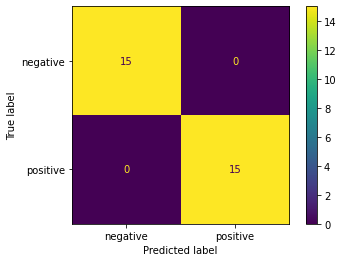

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

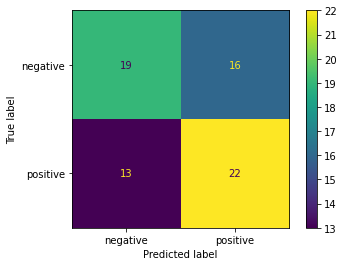

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [28]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.59375    0.57894737]
Recall: [0.54285714 0.62857143]
F1: [0.56716418 0.60273973]


### Training and evaluating a model using TF-IDF

In [29]:
model = RandomForestClassifier()

In [30]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [31]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

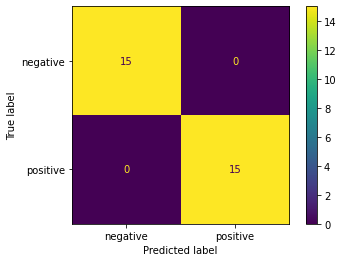

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

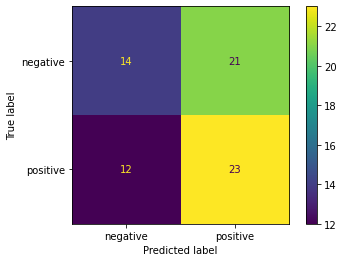

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [34]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.53846154 0.52272727]
Recall: [0.4        0.65714286]
F1: [0.45901639 0.58227848]


### How interpret the results?

### Analyzing errors

In [35]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [36]:
error_df1.shape

(70, 3)

In [37]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
1,"Yo solo diré que Dios tenga piedad de Colombia en esas elecciones porque de verdad, nos va a llevar el que nos trajo.",negative,positive
2,Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia\r\n #TalCual #ClaroyRaspao #AmigosDeNuevo \r\n https://t.co/Kpm7VZPOox https://t.co/KpaZYf7BID,positive,negative
3,Procuraduría alerta que 2.925 jurados de votación están inhabilitados para elecciones Colombia via @ElColombiano https://t.co/i62hR3wv5r,positive,negative
6,"@PaulaAn26992616 @Gmo_Leal Hay que tener mucho cuidado con la sabandija del registrador, nos quiere democratizar las elecciones en nuestras propias narices, ojo Colombia votar masivamente desde temprano por Fico presidente",negative,positive
7,"Cómo es posible afirmar que hay democracia en Colombia cuando estamos realizando elecciones a la presidencia en medio de la guerra contra la población? Como diría la filósofa Hannah Arendt, allí donde comienza la violencia, termina la política\r\n #ParenLaGuerra",negative,positive
13,@CARLOSFMEJIA @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA ¿Fraude?\r\n Buscan fraude donde no lo hay \r\n A lo Donald Trump\r\n ¿Que es lo que vienes?\r\n ¿Los borregos burribistas asaltando al congreso si pierden las elecciones?,negative,positive
14,"En nuestro país, siempre se debe pensar mal. Seguro el paro armado, la policía quieta, todo tan cerca de elecciones. Duque agilizando la extradición de Otoniel… en fin. Esto es Colombia.",positive,negative
15,"Tienen todo listo para robarse las elecciones otra ves, ojo Colombia. https://t.co/toGqlfbrSX",negative,positive
20,@Oscarkast13 @palana61 Será que Colombia está a punto de vivir en carne propia lo sucedido en las elecciones de los Estados Unidos? \r\n Que guarden este trino también. \r\n 🍿🐸🍿\r\n 🤣🤣🤣,positive,negative
21,COLOMBIA NO HABÍA VISTO NUNCA UN PAYASO IGUAL. https://t.co/vfogIcbmmR,negative,positive


### Analyzing errors TF-IDF

In [38]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [39]:
error_df2.shape

(70, 3)

In [40]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
0,"@MONYRODRIGUEZOF por que no pide la renuncia del registrador después del fraude que cometió en las elecciones? o por que no pide la renuncia del KK’s frente a las visitas de la picota, compra de votos o infiltraciones de la campaña? Celebra usted la corrupción y ataca\r\n quienes defienden Colombia",negative,positive
1,"Yo solo diré que Dios tenga piedad de Colombia en esas elecciones porque de verdad, nos va a llevar el que nos trajo.",negative,positive
2,Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia\r\n #TalCual #ClaroyRaspao #AmigosDeNuevo \r\n https://t.co/Kpm7VZPOox https://t.co/KpaZYf7BID,positive,negative
3,Procuraduría alerta que 2.925 jurados de votación están inhabilitados para elecciones Colombia via @ElColombiano https://t.co/i62hR3wv5r,positive,negative
6,"@PaulaAn26992616 @Gmo_Leal Hay que tener mucho cuidado con la sabandija del registrador, nos quiere democratizar las elecciones en nuestras propias narices, ojo Colombia votar masivamente desde temprano por Fico presidente",negative,positive
7,"Cómo es posible afirmar que hay democracia en Colombia cuando estamos realizando elecciones a la presidencia en medio de la guerra contra la población? Como diría la filósofa Hannah Arendt, allí donde comienza la violencia, termina la política\r\n #ParenLaGuerra",negative,positive
12,"@SANTAMARIAURIBE @Registraduria La Registraduría Colombia está manejada por el gobierno, así que si hay una organización criminal es del mismo gobierno, ahora que les ""salió el tiro por la culata"" es otra cosa. \r\n Así que cuál repetir elecciones, no sea cínico.",negative,positive
13,@CARLOSFMEJIA @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA ¿Fraude?\r\n Buscan fraude donde no lo hay \r\n A lo Donald Trump\r\n ¿Que es lo que vienes?\r\n ¿Los borregos burribistas asaltando al congreso si pierden las elecciones?,negative,positive
14,"En nuestro país, siempre se debe pensar mal. Seguro el paro armado, la policía quieta, todo tan cerca de elecciones. Duque agilizando la extradición de Otoniel… en fin. Esto es Colombia.",positive,negative
15,"Tienen todo listo para robarse las elecciones otra ves, ojo Colombia. https://t.co/toGqlfbrSX",negative,positive
